# Task
Find the actual component values of the bandpass filter in fig. 1.

1. Compare the measured response voltage $U_a$ with the expected response voltage with nominal component values and determine the root mean square error. 
2. Minimize the rmse for different component values to find the actual component values.

![Circuit Diagramm](circuit.png)

In [81]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sci

# Get Data

In [82]:
COIL=9e-3
CAPACITOR=1000e-6

def get_measured_voltage(filename):    
    # import measured data from file and create DataFrame
    with np.load(filename) as file:
        return pd.DataFrame({"time" : file["t_mess"], "measured" : file["u_a_mess"]})

def calculate_voltage(coil, capacitor, time_points):
    # return calculated voltage by creating LTI System with given parameters
    RESISTOR=20
    INPUT_VOLTAGE = 2

    numerator=[1/(RESISTOR*capacitor), 0]
    denominator=[1, 1/(RESISTOR*capacitor), 1/(coil*capacitor)]
    transfer_function=sci.signal.TransferFunction(numerator, denominator)

    return INPUT_VOLTAGE*sci.signal.step(transfer_function, T=time_points)[1]

u_a = get_measured_voltage("messwerte.npz")
u_a["calculated"] = calculate_voltage(COIL, CAPACITOR, u_a["time"]) # append dataframe with expected values

# Analysis
## Plot Expected and Measured Data

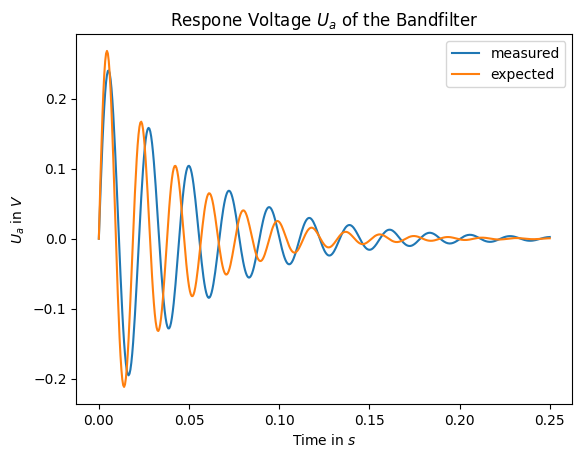

In [83]:
plt.plot(u_a["time"], u_a["measured"], label="measured")
plt.plot(u_a["time"], u_a["calculated"], label='expected')

plt.title("Respone Voltage $U_a$ of the Bandfilter")
plt.xlabel("Time in $s$")
plt.ylabel("$U_a$ in $V$")
plt.legend()

plt.show()

## Calculate Root Mean Square Error

In [84]:
def root_mean_square_error(calculated, true_values): 
    # Calculate the root mean square error of 2 1D arrays
    return np.round(np.sqrt(1/len(calculated) * np.sum(np.square(np.subtract(calculated, true_values)))) *10**6, 2)

rsme = root_mean_square_error(u_a["calculated"], u_a["measured"])
print(f"root mean square error with nominal values: {rsme} e-6 V")

root mean square error with nominal values: 64993.98 e-6 V


## Create RMSE Grid

In [85]:
STEPS = 20

def rsme_grid(steps, time_values, true_values):
    # reserve array space
    Z = np.zeros((steps, steps))

    # create grid
    COIL_LOWER = 7e-3
    COIL_UPPER = 12e-3
    CAPACITOR_LOWER = 9 * 100e-6
    CAPACITOR_UPPER = 16 * 100e-6
    coil_list = np.linspace(COIL_LOWER, COIL_UPPER, steps)
    capacitor_list = np.linspace(CAPACITOR_LOWER, CAPACITOR_UPPER, steps) 

    x, y = np.meshgrid(coil_list, capacitor_list)

    # find rsme for each coil and capacitor values
    for i in range(steps):
        for j in range(steps):
            Z[i][j] = root_mean_square_error(calculate_voltage(coil_list[i], capacitor_list[j], time_values), true_values)

    return x,y,Z

x,y,Z = rsme_grid(STEPS, u_a["time"], u_a["measured"])

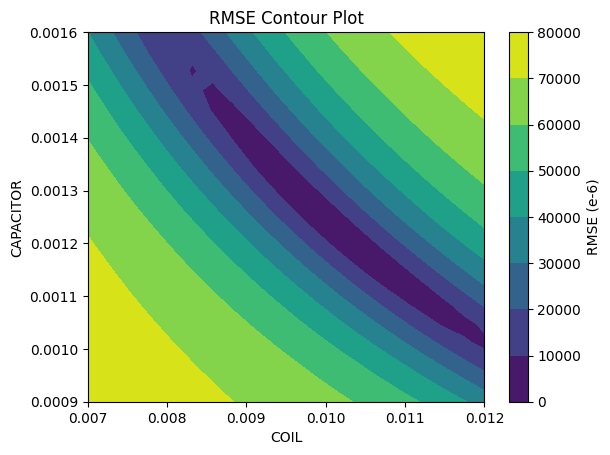

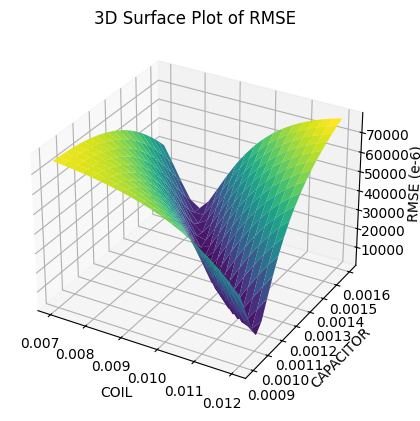

In [86]:
plt.contourf(x, y, Z)
plt.xlabel('COIL')
plt.ylabel('CAPACITOR')
plt.colorbar(label='RMSE (e-6)')
plt.title('RMSE Contour Plot')
plt.show()

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, Z, cmap='viridis')
ax.set_xlabel('COIL')
ax.set_ylabel('CAPACITOR')
ax.set_zlabel('RMSE (e-6)')
plt.title('3D Surface Plot of RMSE')
plt.show()

## Minimize rsme with variable parameters

In [89]:
initial_guess = [COIL, CAPACITOR]

result = sci.optimize.minimize(rsme, initial_guess, args=(STEPS, u_a["time"], u_a["measured"]))
print(result)


# best_coil, best_capacitor = result.x
# min_rmse = result.fun

# print(f"Optimal COIL: {best_coil}, Optimal CAPACITOR: {best_capacitor}, Minimum RMSE: {min_rmse}")

TypeError: rsme_grid() takes 3 positional arguments but 4 were given